In [491]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [492]:
%%R
library(tidyverse)
library(ggpubr)
library(ggalluvial)
library(phyloseq)
source("R/theme.R")

## Metadata, profile

In [493]:
%%R
metadata <-
    read_tsv("metadata/samples_metadata_imm_272S.tsv") %>% data.frame()
metadata$Vac_Group <- factor(metadata$Vac_Group, levels=c("BioNTech", "SinoVac"))
rownames(metadata) <- metadata$sample_id

Rows: 272 Columns: 57
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): sample_id, ID, TimePoint, Cohort, Vac_Group, Dose1_AE_num_cat, Dos...
dbl (50): all_bray_cluster3, Age, Male, BMI, OWOB, Obese_bin, HTC_bin, DMC_b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [494]:
%%R
tax_s <- read_tsv("data/metaphlan3.merged.abundance.profile.species.272S.tsv")
tax_p <- read_tsv("data/metaphlan3.merged.abundance.profile.phylum.272S.tsv")

Rows: 547 Columns: 273
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): clade_name
dbl (272): VAC003B-M1_S2, VAC005B-M1_S3, VAC007B-M1_S4, VAC010B-M1_S5, VAC01...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 12 Columns: 273
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): clade_name
dbl (272): VAC003B-M1_S2, VAC005B-M1_S3, VAC007B-M1_S4, VAC010B-M1_S5, VAC01...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [495]:
%%R
species_phylum <-
    tax_s %>%
    select(clade_name) %>%
    rowwise(clade_name) %>% 
    mutate(clade=str_split(clade_name, "\\|s__")[[1]][2]) %>%
    mutate(phylum=str_split(str_split(clade_name, "\\|")[[1]][2], "p__")[[1]][2]) %>%
    ungroup() %>%
    select(clade, phylum) %>%
    mutate(clade=str_replace(clade, "_", " "))

In [496]:
%%R
species_phylum

# A tibble: 547 × 2
   clade                           phylum        
   <chr>                           <chr>         
 1 Methanobrevibacter smithii      Euryarchaeota 
 2 Methanosphaera stadtmanae       Euryarchaeota 
 3 Actinobaculum sp_oral_taxon_183 Actinobacteria
 4 Actinomyces graevenitzii        Actinobacteria
 5 Actinomyces johnsonii           Actinobacteria
 6 Actinomyces massiliensis        Actinobacteria
 7 Actinomyces naeslundii          Actinobacteria
 8 Actinomyces odontolyticus       Actinobacteria
 9 Actinomyces oris                Actinobacteria
10 Actinomyces sp_HMSC035G02       Actinobacteria
# … with 537 more rows


In [497]:
%%R
tax_s_pls <- phyloseq(
    otu_table(tax_s %>% column_to_rownames("clade_name"), taxa_are_rows=TRUE),
    sample_data(metadata))

tax_p_pls <- phyloseq(
    otu_table(tax_p %>% column_to_rownames("clade_name"), taxa_are_rows=TRUE),
    sample_data(metadata))

In [498]:
%%R
tax_s_l <-
    tax_s %>%
    rowwise() %>%
    mutate(clade=str_replace(str_split(clade_name, "\\|s__")[[1]][2], "_", " ")) %>%
    ungroup() %>%
    pivot_longer(
        names_to="sample_id",
        values_to="abundance",
        -c(clade_name, clade))

dim(tax_s_l)

[1] 148784      4


In [499]:
%%R
547 * 272

[1] 148784


In [500]:
%%R
tax_p_l <-
    tax_p %>%
    rowwise() %>%
    mutate(clade=str_split(clade_name, "\\|p__")[[1]][2]) %>%
    pivot_longer(
        names_to="sample_id",
        values_to="abundance",
        -c(clade_name, clade))

dim(tax_s_l)

[1] 148784      4


In [ ]:
##

In [340]:
%%R
phylum_color_values2 <- c("Firmicutes"="#E69F00",
                         "Bacteroidetes"="#009E73",
                         "Actinobacteria"="#0072B2",
                         "Proteobacteria"="#D55E00",
                         "Synergistetes"="#F0E442",
                         "Others"="#CC79A7")

In [501]:
%%R
#tax_p_l <-
#    tax_p %>%
#    as.data.frame() %>%
#    rownames_to_column("Phylum") %>%
#    rowwise() %>%
#    mutate(Phylum=str_split(Phylum, "\\|")[[1]][2]) %>%
#    ungroup() %>%
#    gather(key="sample_id", value="Abundance", -c(Phylum))

gen_data <- function(tax_l, topn=10) {
    tax_occr <-
        tax_l %>%
        group_by(clade) %>%
        summarize(occr=sum(abundance>0)/length(abundance),
                  mean_abundance=sum(abundance)/length(abundance),
                  median_abundance=median(abundance),
                  abun_quartile_0=quantile(abundance, 0.00),
                  abun_quartile_25=quantile(abundance, 0.25),
                  abun_quartile_50=quantile(abundance, 0.50),
                  abun_quartile_75=quantile(abundance, 0.75),
                  abun_quartile_100=quantile(abundance, 1.00)) %>%
        arrange(desc(mean_abundance, occr)) %>%
        ungroup()

    tax_l <- tax_l %>% left_join(tax_occr)
    
    top_clade_by_abun <- tax_occr %>% arrange(desc(mean_abundance)) %>% slice(1:topn)
    tax_l_top_clade <- top_clade_by_abun %>% left_join(tax_l)

    other_clade_abun <- 
        tax_l_top_clade %>%
        group_by(sample_id) %>%
        summarize(abundance=1-sum(abundance)) %>%
        mutate(clade="Others")

    tax_l_top_clade_add_others <-
        tax_l_top_clade %>%
        select(sample_id, abundance, clade) %>%
        bind_rows(other_clade_abun)

    order_samples_p <-
        tax_l_top_clade_add_others %>%
        filter(clade==top_clade_by_abun$clade[1]) %>%
        arrange(abundance) %>% select(sample_id) %>% as_tibble()
    
    tax_l_top_clade_add_others_add_metadata <-
        tax_l_top_clade_add_others %>%
        left_join(metadata) %>%
        mutate(sample_id = factor(sample_id, levels=order_samples_p$sample_id),
               clade=factor(clade, levels=c("Others", rev(top_clade_by_abun$clade))))
    
    tax_l_top_clade_add_others_add_metadata_group <-
        tax_l_top_clade_add_others_add_metadata %>%
        #group_by(Vac_Group, TimePoint, clade) %>%
        group_by(TimePoint, clade) %>%
        summarise(group_mean_abundance=mean(abundance)) %>%
        ungroup() %>%
        mutate(abun=paste0(round(group_mean_abundance*100, 1), "%")) #%>%
        #mutate(clade=factor(clade, levels(c("Others", rev(top_clade_by_abun$clade)))))
        #mutate(Tot=sum(group_mean_abundance)) %>%
        #group_by(clade) %>%
        #mutate(CUM= cumsum(group_mean_abundance), DomSize=max(CUM)) %>%
        #ungroup()
    
    #print(top_clade_by_abun$clade)
    #print(tax_l_top_clade_add_others_add_metadata_group)
    
    #DomBot <- unique(select(tax_l_top_clade_add_others_add_metadata_group, clade, Tot, DomSize)) %>% 
    #    ungroup() %>% mutate(Bottom=Tot-cumsum(DomSize))
    
    #tax_l_top_clade_add_others_add_metadata_group <-
    #    tax_l_top_clade_add_others_add_metadata_group %>%
    #    inner_join(DomBot %>% select(clade, Bottom)) %>%
    #    mutate(Pos=Bottom + CUM - group_mean_abundance/2) #%>%
       
    
    #print(tax_l_top_clade_add_others_add_metadata_group)
    
    return(list(tax=tax_l_top_clade_add_others_add_metadata,
                group=tax_l_top_clade_add_others_add_metadata_group,
                top=top_clade_by_abun))
}

In [502]:
%%R
#tax_p_l <-
#    tax_p %>%
#    as.data.frame() %>%
#    rownames_to_column("Phylum") %>%
#    rowwise() %>%
#    mutate(Phylum=str_split(Phylum, "\\|")[[1]][2]) %>%
#    ungroup() %>%
#    gather(key="sample_id", value="Abundance", -c(Phylum))

gen_data2 <- function(tax_l, topn) {
    tax_occr <-
        tax_l %>%
        group_by(clade) %>%
        summarize(occr=sum(abundance>0)/length(abundance),
                  mean_abundance=sum(abundance)/length(abundance),
                  median_abundance=median(abundance),
                  abun_quartile_0=quantile(abundance, 0.00),
                  abun_quartile_25=quantile(abundance, 0.25),
                  abun_quartile_50=quantile(abundance, 0.50),
                  abun_quartile_75=quantile(abundance, 0.75),
                  abun_quartile_100=quantile(abundance, 1.00)) %>%
        arrange(desc(mean_abundance, occr)) %>%
        ungroup()

    tax_l <- tax_l %>% left_join(tax_occr)
    
    #top_clade_by_abun <- tax_occr %>% arrange(desc(mean_abundance)) %>% slice(1:topn)
    top_clade_by_abun <- tax_occr %>% filter(clade %in% topn)
    tax_l_top_clade <- top_clade_by_abun %>% left_join(tax_l)

    other_clade_abun <- 
        tax_l_top_clade %>%
        group_by(sample_id) %>%
        summarize(abundance=1-sum(abundance)) %>%
        mutate(clade="Others")

    tax_l_top_clade_add_others <-
        tax_l_top_clade %>%
        select(sample_id, abundance, clade) %>%
        bind_rows(other_clade_abun)

    order_samples_p <-
        tax_l_top_clade_add_others %>%
        filter(clade==top_clade_by_abun$clade[1]) %>%
        arrange(abundance) %>% select(sample_id) %>% as_tibble()
    
    tax_l_top_clade_add_others_add_metadata <-
        tax_l_top_clade_add_others %>%
        left_join(metadata) %>%
        mutate(sample_id = factor(sample_id, levels=order_samples_p$sample_id),
               clade=factor(clade, levels=c("Others", rev(top_clade_by_abun$clade))))
    
    tax_l_top_clade_add_others_add_metadata_group <-
        tax_l_top_clade_add_others_add_metadata %>%
        #group_by(Vac_Group, TimePoint, clade) %>%
        group_by(TimePoint, clade) %>%
        summarise(group_mean_abundance=mean(abundance)) %>%
        ungroup() %>%
        mutate(abun=paste0(round(group_mean_abundance*100, 1), "%"))# %>%
        #mutate(clade=factor(clade, levels(c("Others", topn))))
    #mutate(Tot=sum(group_mean_abundance)) %>%
    #group_by(clade) %>%
    #mutate(CUM= cumsum(group_mean_abundance), DomSize=max(CUM))
    
    #DomBot <- unique(select(tax_l_top_clade_add_others_add_metadata_group, clade, Tot, DomSize)) %>% 
    #    ungroup() %>% mutate(Bottom=Tot-cumsum(DomSize))
    
    #tax_l_top_clade_add_others_add_metadata_group <-
    #    tax_l_top_clade_add_others_add_metadata_group %>%
    #    inner_join(DomBot %>% select(clade, Bottom)) %>%
    #    mutate(Pos=Bottom + CUM - group_mean_abundance/2)# %>%
        #mutate(clade=factor(clade, levels(c("Others", rev(top_clade_by_abun$clade)))))
    
    return(list(tax=tax_l_top_clade_add_others_add_metadata,
                group=tax_l_top_clade_add_others_add_metadata_group,
                top=top_clade_by_abun))
}

In [504]:
%%R
tax_s_top <- gen_data(tax_s_l %>% filter(!str_detect(sample_id, "HKU171")))
tax_p_top <- gen_data(tax_p_l %>% filter(!str_detect(sample_id, "HKU171")), 5)

Joining, by = "clade"
Joining, by = c("clade", "occr", "mean_abundance", "median_abundance", "abun_quartile_0", "abun_quartile_25", "abun_quartile_50", "abun_quartile_75", "abun_quartile_100")
Joining, by = "sample_id"
`summarise()` has grouped output by 'TimePoint'. You can override using the `.groups` argument.
Joining, by = "clade"
Joining, by = c("clade", "occr", "mean_abundance", "median_abundance", "abun_quartile_0", "abun_quartile_25", "abun_quartile_50", "abun_quartile_75", "abun_quartile_100")
Joining, by = "sample_id"
`summarise()` has grouped output by 'TimePoint'. You can override using the `.groups` argument.


In [506]:
%%R
tax_s1_top <- gen_data2(tax_s_l %>% filter(str_detect(sample_id, "HKU171")), tax_s_top$top$clade)
tax_p1_top <- gen_data2(tax_p_l %>% filter(str_detect(sample_id, "HKU171")), tax_p_top$top$clade)

Joining, by = "clade"
Joining, by = c("clade", "occr", "mean_abundance", "median_abundance", "abun_quartile_0", "abun_quartile_25", "abun_quartile_50", "abun_quartile_75", "abun_quartile_100")
Joining, by = "sample_id"
`summarise()` has grouped output by 'TimePoint'. You can override using the `.groups` argument.
Joining, by = "clade"
Joining, by = c("clade", "occr", "mean_abundance", "median_abundance", "abun_quartile_0", "abun_quartile_25", "abun_quartile_50", "abun_quartile_75", "abun_quartile_100")
Joining, by = "sample_id"
`summarise()` has grouped output by 'TimePoint'. You can override using the `.groups` argument.


In [507]:
%%R
clade_levels <- levels(tax_s_top$group$clade)
tax_s1_top$group$clade <- factor(tax_s1_top$group$clade, levels=clade_levels)
tax_s_top$group$clade <- factor(tax_s_top$group$clade, levels=clade_levels)

In [508]:
%%R
clade_levels2 <- levels(tax_p_top$group$clade)
tax_p1_top$group$clade <- factor(tax_p1_top$group$clade, levels=clade_levels2)
tax_p_top$group$clade <- factor(tax_p_top$group$clade, levels=clade_levels2)

## Extended Data Figure 3a

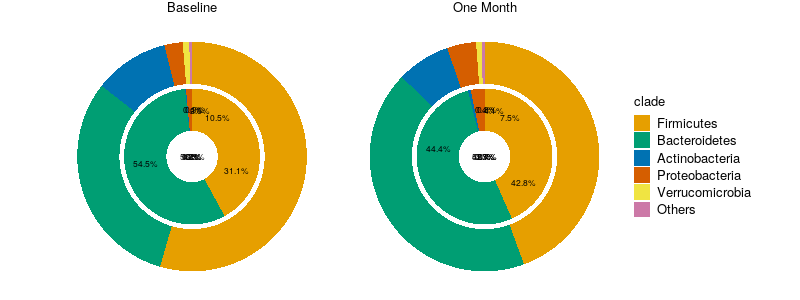

In [760]:
%%R -w 800 -h 300

phylum_color_values <- c("Firmicutes"="#E69F00",
                         "Bacteroidetes"="#009E73",
                         "Actinobacteria"="#0072B2",
                         "Proteobacteria"="#D55E00",
                         "Verrucomicrobia"="#F0E442",
                         "Others"="#CC79A7")

p <- ggplot() +
    geom_col(data=tax_p_top$group,
             aes(x = 4, y = group_mean_abundance, fill = clade)) +
    geom_col(data=tax_p1_top$group,
             aes(x = 3, y = group_mean_abundance, fill = clade)) +
    #geom_bar(stat = "identity", color = "white") +
    coord_polar(theta = "y") +
    geom_text(aes(y=group_mean_abundance, x=3, label = abun),
              position=position_stack(vjust=0.5),
              data=tax_p_top$group, size=3, color = "black") +
    geom_text(aes(y = group_mean_abundance, x=2, label = abun),
              position=position_stack(vjust=0.5),
              data=tax_p1_top$group, size=3, color = "black") +
    scale_fill_manual(values=phylum_color_values) +
    theme_void()+
    #xlim(1, 20) +
    #labs(x=NULL, y=NULL) +
    facet_wrap(~TimePoint, labeller=labeller(TimePoint=timepoint_labels)) +
    theme(strip.text.x = element_text(size = 13),
          legend.title = element_text(size = 13,color = "black"),
          legend.text = element_text(size = 13,color = "black"))

print(p)
ggsave("figures/abundance_distribution/HKU171_phylum_donut_chart3.pdf", p, width=10, height=10)

##

## Extended Data Figure 3b

In [ ]:
%%R
phylum_color_values <- c("Firmicutes"="#E69F00",
                         "Bacteroidetes"="#009E73",
                         "Actinobacteria"="#0072B2",
                         "Proteobacteria"="#D55E00",
                         "Verrucomicrobia"="#F0E442",
                         "Others"="#CC79A7") %>% data.frame() %>% rownames_to_column("phylum")
colnames(phylum_color_values) <- c("phylum", "color")

In [ ]:
##

In [ ]:
%%R
gen2_data_mean <- function(tax_l, topn=25) {
    tax_occr <-
        tax_l %>%
        group_by(clade) %>%
        summarize(occr=sum(abundance>0)/length(abundance),
                  mean_abundance=sum(abundance)/length(abundance),
                  median_abundance=median(abundance),
                  abun_quartile_0=quantile(abundance, 0.00),
                  abun_quartile_25=quantile(abundance, 0.25),
                  abun_quartile_50=quantile(abundance, 0.50),
                  abun_quartile_75=quantile(abundance, 0.75),
                  abun_quartile_100=quantile(abundance, 1.00)) %>%
        arrange(desc(mean_abundance, occr)) %>%
        #arrange(desc(mean_abundance, median_abundance, occr)) %>%
        ungroup()

    tax_l <- tax_l %>% left_join(tax_occr)
    
    top_clade_by_abun <- tax_occr %>% arrange(desc(mean_abundance)) %>% slice(1:topn)
    tax_l_top_clade <- top_clade_by_abun %>% left_join(tax_l)

    other_clade_abun <- 
        tax_l_top_clade %>%
        group_by(sample_id) %>%
        summarize(abundance=1-sum(abundance)) %>%
        mutate(clade="Others")

    tax_l_top_clade_add_others <-
        tax_l_top_clade %>%
        select(sample_id, abundance, clade) %>%
        bind_rows(other_clade_abun)

    order_samples_p <-
        tax_l_top_clade_add_others %>%
        filter(clade==top_clade_by_abun$clade[1]) %>%
        arrange(abundance) %>% select(sample_id) %>% as_tibble()
    
    tax_l_top_clade_add_others_add_metadata <-
        tax_l_top_clade_add_others %>%
        left_join(metadata) %>%
        mutate(sample_id = factor(sample_id, levels=order_samples_p$sample_id),
               clade=factor(clade, levels=c("Others", rev(top_clade_by_abun$clade))))
    
    tax_l_top_clade_add_others_add_metadata_group <-
        tax_l_top_clade_add_others_add_metadata %>%
        #group_by(Vac_Group, TimePoint, clade) %>%
        group_by(TimePoint, clade) %>%
        summarise(group_mean_abundance=mean(abundance)) %>%
        ungroup() %>%
        mutate(abun=paste0(round(group_mean_abundance*100, 1), "%")) #%>%
        #mutate(clade=factor(clade, levels(c("Others", rev(top_clade_by_abun$clade)))))
        #mutate(Tot=sum(group_mean_abundance)) %>%
        #group_by(clade) %>%
        #mutate(CUM= cumsum(group_mean_abundance), DomSize=max(CUM)) %>%
        #ungroup()
    
    #print(top_clade_by_abun$clade)
    #print(tax_l_top_clade_add_others_add_metadata_group)
    
    #DomBot <- unique(select(tax_l_top_clade_add_others_add_metadata_group, clade, Tot, DomSize)) %>% 
    #    ungroup() %>% mutate(Bottom=Tot-cumsum(DomSize))
    
    #tax_l_top_clade_add_others_add_metadata_group <-
    #    tax_l_top_clade_add_others_add_metadata_group %>%
    #    inner_join(DomBot %>% select(clade, Bottom)) %>%
    #    mutate(Pos=Bottom + CUM - group_mean_abundance/2) #%>%
       
    
    #print(tax_l_top_clade_add_others_add_metadata_group)
    
    return(list(tax=tax_l_top_clade_add_others_add_metadata,
                group=tax_l_top_clade_add_others_add_metadata_group,
                top=top_clade_by_abun))
}

In [ ]:
%%R
#tax_p_l <-
#    tax_p %>%
#    as.data.frame() %>%
#    rownames_to_column("Phylum") %>%
#    rowwise() %>%
#    mutate(Phylum=str_split(Phylum, "\\|")[[1]][2]) %>%
#    ungroup() %>%
#    gather(key="sample_id", value="Abundance", -c(Phylum))

gen2_data2_mean <- function(tax_l, topn) {
    tax_occr <-
        tax_l %>%
        group_by(clade) %>%
        summarize(occr=sum(abundance>0)/length(abundance),
                  mean_abundance=sum(abundance)/length(abundance),
                  median_abundance=median(abundance),
                  abun_quartile_0=quantile(abundance, 0.00),
                  abun_quartile_25=quantile(abundance, 0.25),
                  abun_quartile_50=quantile(abundance, 0.50),
                  abun_quartile_75=quantile(abundance, 0.75),
                  abun_quartile_100=quantile(abundance, 1.00)) %>%
        arrange(desc(mean_abundance, occr)) %>%
        ungroup()

    tax_l <- tax_l %>% left_join(tax_occr)
    
    #top_clade_by_abun <- tax_occr %>% arrange(desc(mean_abundance)) %>% slice(1:topn)
    top_clade_by_abun <- tax_occr %>% filter(clade %in% topn)
    tax_l_top_clade <- top_clade_by_abun %>% left_join(tax_l)

    other_clade_abun <- 
        tax_l_top_clade %>%
        group_by(sample_id) %>%
        summarize(abundance=1-sum(abundance)) %>%
        mutate(clade="Others")

    tax_l_top_clade_add_others <-
        tax_l_top_clade %>%
        select(sample_id, abundance, clade) %>%
        bind_rows(other_clade_abun)

    order_samples_p <-
        tax_l_top_clade_add_others %>%
        filter(clade==top_clade_by_abun$clade[1]) %>%
        arrange(abundance) %>% select(sample_id) %>% as_tibble()
    
    tax_l_top_clade_add_others_add_metadata <-
        tax_l_top_clade_add_others %>%
        left_join(metadata) %>%
        mutate(sample_id = factor(sample_id, levels=order_samples_p$sample_id),
               clade=factor(clade, levels=c("Others", rev(top_clade_by_abun$clade))))
    
    tax_l_top_clade_add_others_add_metadata_group <-
        tax_l_top_clade_add_others_add_metadata %>%
        #group_by(Vac_Group, TimePoint, clade) %>%
        group_by(TimePoint, clade) %>%
        summarise(group_mean_abundance=mean(abundance)) %>%
        ungroup() %>%
        mutate(abun=paste0(round(group_mean_abundance*100, 1), "%"))# %>%
        #mutate(clade=factor(clade, levels(c("Others", topn))))
    #mutate(Tot=sum(group_mean_abundance)) %>%
    #group_by(clade) %>%
    #mutate(CUM= cumsum(group_mean_abundance), DomSize=max(CUM))
    
    #DomBot <- unique(select(tax_l_top_clade_add_others_add_metadata_group, clade, Tot, DomSize)) %>% 
    #    ungroup() %>% mutate(Bottom=Tot-cumsum(DomSize))
    
    #tax_l_top_clade_add_others_add_metadata_group <-
    #    tax_l_top_clade_add_others_add_metadata_group %>%
    #    inner_join(DomBot %>% select(clade, Bottom)) %>%
    #    mutate(Pos=Bottom + CUM - group_mean_abundance/2)# %>%
        #mutate(clade=factor(clade, levels(c("Others", rev(top_clade_by_abun$clade)))))
    
    return(list(tax=tax_l_top_clade_add_others_add_metadata,
                group=tax_l_top_clade_add_others_add_metadata_group,
                top=top_clade_by_abun))
}

In [748]:
%%R -w 1000 -h 600
tax2_s_top <- gen2_data_mean(tax_s_l %>% filter(!str_detect(sample_id, "HKU171")), 12)
tax2_s1_top <- gen2_data2_mean(tax_s_l %>% filter(str_detect(sample_id, "HKU171")), tax2_s_top$top$clade)

clade_phylum <-
    tax2_s_top$top %>% select(clade) %>% left_join(species_phylum) %>%
    mutate(clade=factor(clade, levels=tax2_s_top$top$clade)) %>%
    mutate(y="")    

tax2_s_top_c <-
    tax2_s_top$group %>% mutate(subjects="Others") %>%
    bind_rows(tax2_s1_top$group %>% mutate(subjects="HKU171")) %>%
    mutate(subjects=factor(subjects, levels=c("HKU171", "Others"))) %>%
    filter(!clade=="Others") %>%
    left_join(species_phylum) %>%
    mutate(clade=factor(clade, levels=tax2_s_top$top$clade))

Joining, by = "clade"
Joining, by = c("clade", "occr", "mean_abundance", "median_abundance", "abun_quartile_0", "abun_quartile_25", "abun_quartile_50", "abun_quartile_75", "abun_quartile_100")
Joining, by = "sample_id"
`summarise()` has grouped output by 'TimePoint'. You can override using the `.groups` argument.
Joining, by = "clade"
Joining, by = c("clade", "occr", "mean_abundance", "median_abundance", "abun_quartile_0", "abun_quartile_25", "abun_quartile_50", "abun_quartile_75", "abun_quartile_100")
Joining, by = "sample_id"
`summarise()` has grouped output by 'TimePoint'. You can override using the `.groups` argument.
Joining, by = "clade"
Joining, by = "clade"


In [727]:
%%R
clade_phylum

# A tibble: 12 × 3
   clade                        phylum         y    
   <fct>                        <chr>          <chr>
 1 Faecalibacterium prausnitzii Firmicutes     ""   
 2 Bacteroides vulgatus         Bacteroidetes  ""   
 3 Bacteroides uniformis        Bacteroidetes  ""   
 4 Prevotella copri             Bacteroidetes  ""   
 5 Bifidobacterium adolescentis Actinobacteria ""   
 6 Eubacterium rectale          Firmicutes     ""   
 7 Bacteroides stercoris        Bacteroidetes  ""   
 8 Roseburia faecis             Firmicutes     ""   
 9 Bacteroides plebeius         Bacteroidetes  ""   
10 Blautia wexlerae             Firmicutes     ""   
11 Eubacterium eligens          Firmicutes     ""   
12 Alistipes putredinis         Bacteroidetes  ""   


In [728]:
%%R
tax2_s_top$top$clade

 [1] "Faecalibacterium prausnitzii" "Bacteroides vulgatus"        
 [3] "Bacteroides uniformis"        "Prevotella copri"            
 [5] "Bifidobacterium adolescentis" "Eubacterium rectale"         
 [7] "Bacteroides stercoris"        "Roseburia faecis"            
 [9] "Bacteroides plebeius"         "Blautia wexlerae"            
[11] "Eubacterium eligens"          "Alistipes putredinis"        


In [749]:
%%R
species_color_12 <- c("Faecalibacterium prausnitzii"="#a6cee3",
                      "Bacteroides uniformis"="#1f78b4",
                      "Bacteroides vulgatus"="#b2df8a",
                      "Blautia wexlerae"="#33a02c",
                      "Eubacterium rectale"="#fb9a99",
                      "Bifidobacterium adolescentis"="#e31a1c",
                      "Eubacterium eligens"="#fdbf6f",
                      "Alistipes putredinis"="#ff7f00",
                      "Prevotella copri"="#cab2d6",
                      "Bacteroides plebeius"="#6a3d9a",
                      "Roseburia faecis"="#ffff99",
                      "Bacteroides stercoris"="#b15928")

species_color_df <- tribble(
    ~clade, ~color_clade,
    "Faecalibacterium prausnitzii", "#a6cee3",
    "Bacteroides uniformis", "#1f78b4",
    "Bacteroides vulgatus", "#b2df8a",
    "Blautia wexlerae", "#33a02c",
    "Eubacterium rectale", "#fb9a99",
    "Bifidobacterium adolescentis", "#e31a1c",
    "Eubacterium eligens", "#fdbf6f",
    "Alistipes putredinis", "#ff7f00",
    "Prevotella copri", "#cab2d6",
    "Bacteroides plebeius", "#6a3d9a",
    "Roseburia faecis", "#ffff99",
    "Bacteroides stercoris", "#b15928")

phylum_color <- c(
    "Firmicutes"="#E69F00",
    "Bacteroidetes"="#009E73",
    "Actinobacteria"="#0072B2",
    "Proteobacteria"="#D55E00",
    "Verrucomicrobia"="#F0E442",
    "Others"="#CC79A7")

phylum_color_df <- tribble(
    ~phylum, ~color_phylum,
    "Firmicutes", "#E69F00",
    "Bacteroidetes", "#009E73",
    "Actinobacteria", "#0072B2",
    "Proteobacteria", "#D55E00",
    "Verrucomicrobia", "#F0E442",
    "Others", "#CC79A7")

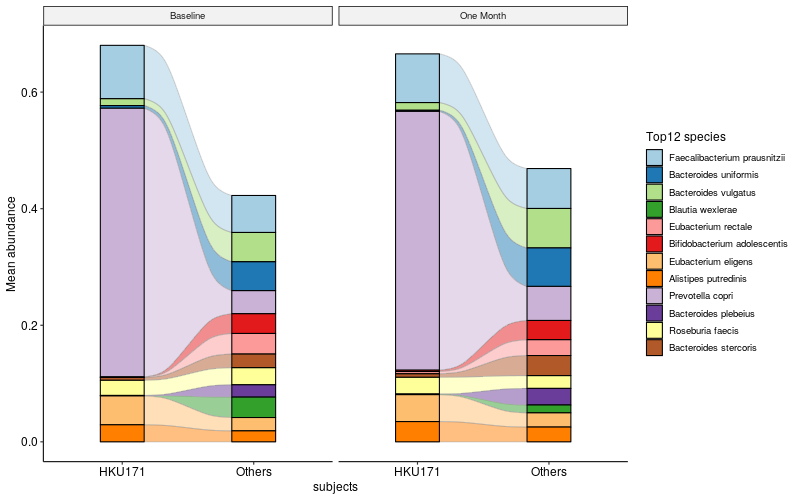

In [750]:
%%R -w 800 -h 500
p <- ggplot(tax2_s_top_c %>% filter(!clade=="Others"),
            aes(x=subjects, y=group_mean_abundance, alluvium=clade, fill=clade)) +
    geom_flow(stat="alluvium", color="darkgray") +
    geom_stratum(stat="alluvium") +
    facet_wrap(~TimePoint, labeller=labeller(TimePoint=timepoint_labels)) +
    scale_fill_manual(values=species_color_12) +
    scale_color_manual(values=species_color_12) +
    ylab("Mean abundance") +
    theme(axis.text.y=element_text(size=13, color="black"),
          axis.ticks = element_blank(),
          panel.grid = element_blank(),
          legend.title = element_text(size = 13,color = "black"),
          legend.text = element_text(size = 13,color = "black"),
          axis.title = element_text(size = 13,color = "black"),
          axis.text = element_text(size = 13,color = "black")) +
    theme(strip.text.x = element_text(size = 13)) +
        scale_x_discrete(labels=c("D0" = "Baseline", "M1" = "One Month")) +
    theme_pubr(legend="right") +
    labs(fill="Top12 species")

print(p)
ggsave(
    "../results/figures/V1/abundance_distribution/HKU171_vs_others_abundance_distribution_mean_group_top12_alluvial.pdf",
width=8, height=5)